### The idea is very intuitive. we will train a n/w that will predict bbox coordinates along with the probability score of the class of object in the image
### when we train a image classifier , we input an image and get probability score as output 
### when we train a detector we will input and image and get along with the probability score , 4 more values representing top left and bottom right (x,y).
### we will have a base n/w for extracting features and two branches one for classification , other for regression

In [30]:
# import the necessary packages
#from pyimagesearch import config
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os

In [31]:
#! pip install opencv-python


In [32]:
### importing the resnet model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression
import imutils

In [74]:
classes_to_label={"dolphin":0,"helicopter":1,"panda":2}
labels_to_class={0:"dolphin",1:"helicopter",2:"panda"}

num_classes=len(classes_to_label)

In [34]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

In [35]:
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",
	name="bounding_box")(bboxHead)
# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(num_classes, activation="softmax",
	name="class_label")(softmaxHead)
# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(
	inputs=vgg.input,
	outputs=(bboxHead, softmaxHead))

In [36]:
#model.summary()

In [37]:
# initialize our initial learning rate, number of epochs to train
# for, and the batch size
lr = 0.0001
num_epochs = 20
batch_size = 32

In [38]:
# define a dictionary to set the loss methods -- categorical
# cross-entropy for the class label head and mean absolute error
# for the bounding box head
losses = {"class_label": "categorical_crossentropy","bounding_box": "mean_squared_error",}
# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {"class_label": 1.0,"bounding_box": 1.0}
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(lr=lr)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

C:\Users\uid38717\Anaconda3\envs\tensorflow_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [39]:
#from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### Preparing the data

In [40]:
import pandas as pd
import random
import os

In [41]:
base_data_path=r"D:\LearningObjectDetection\data\caltech-101_mini"
base_ann_path=os.path.join(base_data_path,"annotations")
base_img_path=os.path.join(base_data_path,"images")
use_categories=["dolphin","helicopter","panda"]

In [42]:
def scale_bbox(src_h,src_w,target_h,target_w):
    x_scale=target_w/w
    y_scale=target_h/h

    x1_=int(x1*x_scale)
    y1_=int(y1*y_scale)
    x2_=int(x2*x_scale)
    y2_=int(y2*y_scale)
    return (x1_,y1_,x2_,y2_)

def normalize_bbox(img_h,img_w,x1,y1,x2,y2):
    # scale the bounding box coordinates relative to the spatial
    # dimensions of the input image
    x1_ = float(x1) / img_w
    y1_ = float(y1) / img_h
    x2_ = float(x2) / img_w
    y2_ = float(y2) / img_h
    return (x1_,y1_,x2_,y2_)

In [43]:
target_h,target_w=224,224

In [44]:
data=[]
labels=[]
bboxes=[]
for category in use_categories:
    vis=True
    print("preparing data for: {}".format(category))
    df_path=os.path.join(base_ann_path,"{}.csv".format(category))
    df=pd.read_csv(df_path)
    for idx,row in df.iterrows():
        label=classes_to_label[category]
        img_name,x1,y1,x2,y2=row[1:]
        img_path=os.path.join(base_img_path,category,img_name)
        img=cv2.imread(img_path)
        img_2=cv2.resize(img,(224,224))
        h,w=img.shape[:2]
        #print(h,w)
        x1_,y1_,x2_,y2_=scale_bbox(h,w,target_h,target_w)
        x1__,y1__,x2__,y2__=normalize_bbox(target_h,target_w,x1_,y1_,x2_,y2_)

        #print(x1,y1,x2,y2)
        #print(x1_,y1_,x2_,y2_)
        #print(x1__,y1__,x2__,y2__)
        #image = load_img(img_path, target_size=(224, 224))
        #image = img_to_array(image)
        #print("image: ",image.shape)
        if vis:
            img_rect=cv2.rectangle(img.copy(),(x1,y1),(x2,y2),color=(255,0,0))
            img_rect_2=cv2.rectangle(img_2,(x1,y1),(x2,y2),color=(255,0,0))
            img_rect_2=cv2.rectangle(img_rect_2,(x1_,y1_),(x2_,y2_),color=(0,255,0))

            cv2.imshow("img",img_rect)
            cv2.imshow("img2",img_rect_2)

            cv2.waitKey(0)
            vis=False
        data.append(img_2)
        labels.append(label)
        bboxes.append((x1__,y1__,x2__,y2__))    
    

preparing data for: dolphin
preparing data for: helicopter
preparing data for: panda


In [45]:
random.seed(52)
merged=list(zip(data,labels,bboxes))
print(len(merged))

print(merged[0][1])
random.shuffle(merged)
print(merged[0][1])

data = [item[0] for item in merged]
labels = [item[1] for item in merged]
bboxes = [item[2] for item in merged]

191
0
0


In [46]:
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")

In [47]:
data.shape

(191, 224, 224, 3)

In [48]:
print(labels)

[0 0 1 0 2 0 2 0 0 1 2 1 1 1 1 1 1 1 0 1 0 1 1 0 2 0 2 1 1 2 1 1 1 1 2 1 1
 1 1 2 0 1 1 0 0 1 0 2 0 2 2 2 0 0 0 1 1 1 1 0 0 1 1 0 0 1 0 2 1 1 1 1 0 0
 2 1 1 0 2 1 1 0 1 1 2 1 1 2 1 0 0 1 1 1 1 1 1 0 2 1 1 1 0 1 2 0 1 2 0 2 0
 0 1 2 1 1 0 2 0 0 1 1 0 0 0 1 1 0 0 2 2 2 0 1 2 0 0 0 0 1 1 0 1 2 1 0 1 1
 2 0 0 2 1 1 1 0 1 2 0 1 1 1 1 2 0 2 0 2 0 0 0 2 1 1 2 0 2 1 1 0 1 0 0 0 1
 1 1 1 2 0 1]


In [49]:
labels_ = to_categorical(labels)
print(labels_)

[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0.

In [50]:
bboxes.shape

(191, 4)

In [51]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(data, labels_, bboxes,test_size=0.20, random_state=42)
# unpack the data split
(train_images, test_images) = split[:2]
(train_labels, test_labels) = split[2:4]
(train_bboxes, test_bboxes) = split[4:6]

In [52]:
print(train_images.shape,test_images.shape)
print(train_labels.shape,test_labels.shape)
print(train_bboxes.shape,test_bboxes.shape)

(152, 224, 224, 3) (39, 224, 224, 3)
(152, 3) (39, 3)
(152, 4) (39, 4)


In [53]:
print(test_labels[0:5])

[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [54]:
train_images[0]

array([[[0.87058824, 0.8156863 , 0.83137256],
        [0.87058824, 0.8156863 , 0.83137256],
        [0.87058824, 0.8156863 , 0.83137256],
        ...,
        [0.87058824, 0.7882353 , 0.8       ],
        [0.8627451 , 0.78039217, 0.7921569 ],
        [0.85882354, 0.7764706 , 0.7882353 ]],

       [[0.87058824, 0.8156863 , 0.83137256],
        [0.87058824, 0.8156863 , 0.83137256],
        [0.87058824, 0.8156863 , 0.83137256],
        ...,
        [0.87058824, 0.7882353 , 0.8       ],
        [0.8627451 , 0.78039217, 0.7921569 ],
        [0.85882354, 0.7764706 , 0.7882353 ]],

       [[0.87058824, 0.8156863 , 0.83137256],
        [0.87058824, 0.8156863 , 0.83137256],
        [0.87058824, 0.8156863 , 0.83137256],
        ...,
        [0.8666667 , 0.78431374, 0.79607844],
        [0.8627451 , 0.78039217, 0.7921569 ],
        [0.85882354, 0.7764706 , 0.7882353 ]],

       ...,

       [[0.13725491, 0.29411766, 0.21176471],
        [0.14509805, 0.3019608 , 0.22352941],
        [0.11764706, 0

In [55]:
# construct a dictionary for our target training outputs
train_targets = {
	"class_label": train_labels,
	"bounding_box": train_bboxes
}
# construct a second dictionary, this one for our target testing
# outputs
test_targets = {
	"class_label": test_labels,
	"bounding_box": test_bboxes
}

In [56]:
# train the network for bounding box regression and class label
# prediction
print("[INFO] training model...")
H = model.fit(
	train_images, train_targets,
	validation_data=(test_images, test_targets),
	batch_size=batch_size,
	epochs=num_epochs,
	verbose=1)
# serialize the model to disk
#print("[INFO] saving object detector model...")
#model.save(config.MODEL_PATH, save_format="h5")
# serialize the label binarizer to disk
#print("[INFO] saving label binarizer...")
#f = open(config.LB_PATH, "wb")
#f.write(pickle.dumps(lb))
#f.close()

[INFO] training model...
Epoch 1/20
5/5 [==============================] - 16s 3s/step - loss: 1.4947 - bounding_box_loss: 0.0575 - class_label_loss: 1.4372 - bounding_box_accuracy: 0.4211 - class_label_accuracy: 0.3750 - val_loss: 0.6820 - val_bounding_box_loss: 0.0148 - val_class_label_loss: 0.6671 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8462
Epoch 2/20
5/5 [==============================] - 15s 3s/step - loss: 0.8514 - bounding_box_loss: 0.0171 - class_label_loss: 0.8343 - bounding_box_accuracy: 0.7171 - class_label_accuracy: 0.6382 - val_loss: 0.5162 - val_bounding_box_loss: 0.0158 - val_class_label_loss: 0.5004 - val_bounding_box_accuracy: 0.7949 - val_class_label_accuracy: 0.9487
Epoch 3/20
5/5 [==============================] - 16s 3s/step - loss: 0.6095 - bounding_box_loss: 0.0159 - class_label_loss: 0.5936 - bounding_box_accuracy: 0.7039 - class_label_accuracy: 0.7632 - val_loss: 0.3359 - val_bounding_box_loss: 0.0160 - val_class_label_loss: 0.3199 - 

In [57]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save("best_model_obj_det_bbox_reg", save_format="h5")
# serialize the label binarizer to disk
#print("[INFO] saving label binarizer...")
#f = open(config.LB_PATH, "wb")
#f.write(pickle.dumps(lb))
#f.close()

[INFO] saving object detector model...


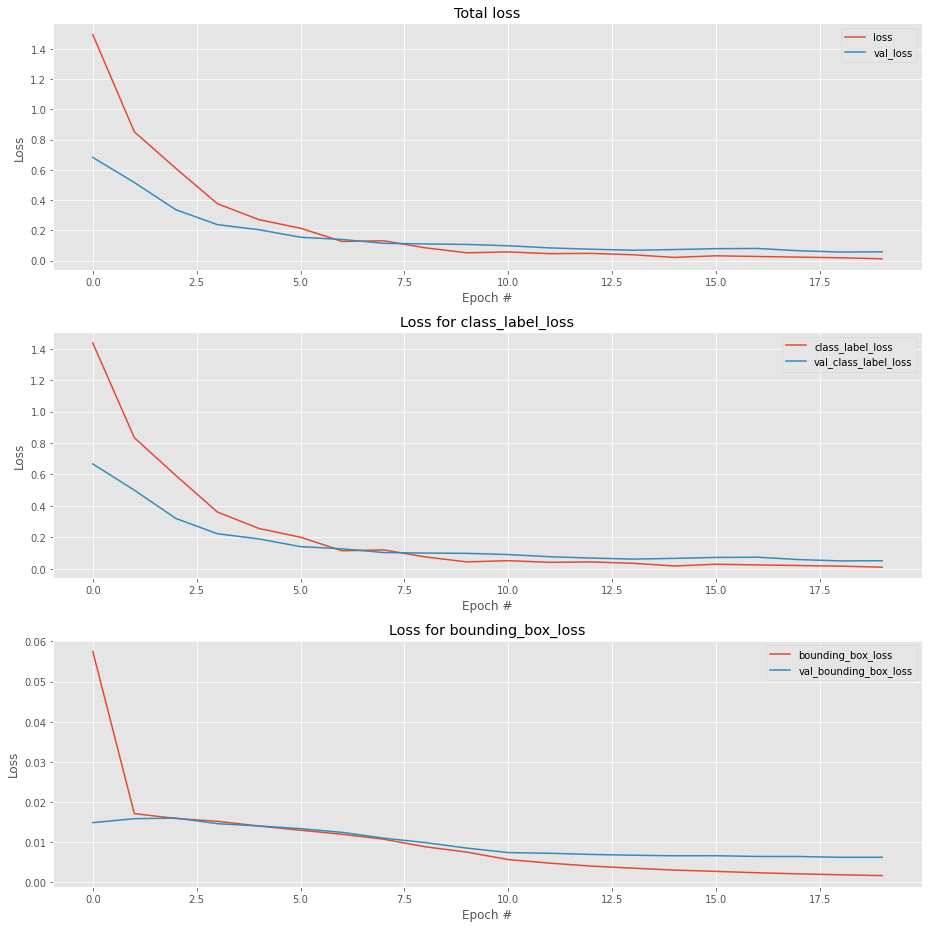

In [60]:
# plot the total loss, label loss, and bounding box loss
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, num_epochs)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(N, H.history[l], label=l)
	ax[i].plot(N, H.history["val_" + l], label="val_" + l)
	ax[i].legend()
# save the losses figure and create a new figure for the accuracies
plt.tight_layout()
#plotPath = os.path.sep.join(["plots", "losses.png"])
plot_path="losses.png"
plt.savefig(plot_path)
plt.show()
plt.close()

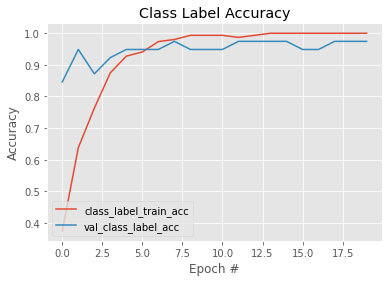

In [61]:
# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
	label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
	label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
# save the accuracies plot
#plot_path = os.path.sep.join([config.PLOTS_PATH, "accs.png"])
plot_path = "accs.png"

plt.savefig(plot_path)
plt.show()
plt.close()

In [65]:
	# predict the bounding box of the object along with the class
	# label
	(box_preds, label_preds) = model.predict(test_images)


2/2 [==============================] - 3s 635ms/step


In [66]:
print(box_preds.shape)
print(label_preds.shape)

(39, 4)
(39, 3)


In [70]:
# determine the class label with the largest predicted
# probability
label_preds = np.argmax(label_preds, axis=1)
label_preds

array([1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 2, 1, 1, 2,
       2, 2, 1, 2, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1], dtype=int64)

In [69]:
box_preds

array([[0.09783674, 0.15607141, 0.92279863, 0.85861635],
       [0.06306472, 0.1273091 , 0.9558998 , 0.869086  ],
       [0.11148161, 0.18223786, 0.92243314, 0.90256697],
       [0.07318557, 0.09121587, 0.9184338 , 0.85542285],
       [0.10747001, 0.17160971, 0.9079489 , 0.7733988 ],
       [0.09797069, 0.19169429, 0.9179567 , 0.8033997 ],
       [0.06673022, 0.16385545, 0.94180334, 0.8503827 ],
       [0.06051809, 0.12110034, 0.94924587, 0.8698731 ],
       [0.11978553, 0.20805308, 0.90289545, 0.80812377],
       [0.120442  , 0.19868095, 0.90575147, 0.8000036 ],
       [0.07461311, 0.17850782, 0.9341081 , 0.7824822 ],
       [0.13179307, 0.17569467, 0.8771098 , 0.7378756 ],
       [0.09437621, 0.16581532, 0.94213116, 0.90345204],
       [0.12317091, 0.21470758, 0.8771515 , 0.8209924 ],
       [0.05480836, 0.09619773, 0.9409213 , 0.8613172 ],
       [0.07819173, 0.09213199, 0.92317057, 0.89284164],
       [0.07589494, 0.11454522, 0.93983835, 0.89628786],
       [0.06603634, 0.12724711,

In [76]:
(h, w) = target_h,target_w

for i in range(len(test_images)):
    test_image=test_images[i]
    label_pred=label_preds[i]
    label=labels_to_class[label_pred]
    box_pred=box_preds[i]
    x1,y1,x2,y2=box_pred
    # scale the predicted bounding box coordinates based on the image
    # dimensions
    x1 = int(x1 * w)
    y1 = int(y1 * h)
    x2 = int(x2 * w)
    y2 = int(y2 * h)
    # draw the predicted bounding box and class label on the image
    y = y1 - 10 if y1 - 10 > 10 else y1 + 10
    cv2.putText(test_image, label, (x1, y), cv2.FONT_HERSHEY_SIMPLEX,0.65, (0, 255, 0), 2)
    cv2.rectangle(test_image, (x1, y1), (x2, y2),(0, 255, 0), 2)
    # show the output image
    cv2.imshow("Output", test_image)
    cv2.waitKey(0)

In [72]:
label_pred

1

### One of the largest limitations of the above approach is that the model can only predict one set of bounding boxes and class labels.